# Customer Segment & Chips Purchasing Behavior Analysis

## Introduction

This project forms part of the **Quantium Virtual Internship**, where the objective is to explore customer purchasing behavior and identify actionable insights that can guide category strategy.

In this analysis, I worked with two datasets — **transaction data** and **customer demographic data** — to understand how different customer segments purchase snack products, particularly chips. The aim is to uncover patterns in sales and behavior that can help **Julia, the Category Manager**, make data-driven decisions for the upcoming category review.

The analysis begins with **data preparation and cleaning**, ensuring the datasets are accurate and consistent. From there, I performed **feature engineering** to extract useful details such as pack size, brand, and customer segments. I then explored the data to identify trends across time and customer groups, looking at **which segments spend the most, how preferences differ by brand, and what drives overall sales performance**.

Throughout the notebook, visualizations are used to bring these insights to life — from pack size distributions and monthly sales trends to brand preferences and spending patterns by customer type. The final section summarizes key findings and strategic implications, showing how understanding customer behavior can directly inform marketing, pricing, and product decisions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Load data

In [2]:
transactionData = pd.read_excel("QVI_transaction_data.xlsx")

In [3]:
customerData = pd.read_csv("QVI_purchase_behaviour.csv")

## Data preparation

The `DATE` field was converted to a proper datetime format for time-based analysis.

In [4]:
from datetime import datetime

transactionData["DATE"] = pd.to_datetime(transactionData["DATE"], origin="1899-12-30", unit="D")

In [5]:
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [6]:
# Check product names
transactionData["PROD_NAME"].nunique()

114

To better understand product names, a **word frequency analysis** was conducted. This surfaced the most recurring terms such as *Chips, Smiths, Crinkle, Cut, Kettle,* and *Doritos*, highlighting the dominant brands and variants in the assortment.

In [7]:
words = []
for name in transactionData["PROD_NAME"].unique():
    words.extend(name.split(" "))

productWords = pd.Series(words)
productWords = productWords.str.lower()  # semua huruf kecil
productWords = productWords[~productWords.str.contains(r"\d")]  # buang angka
productWords = productWords.str.replace(r"[^a-z]", "", regex=True)  # buang karakter khusus
productWords = productWords[productWords != ""]  # buang string kosong

productWords.value_counts().head(20)

chips       21
smiths      16
crinkle     14
cut         14
kettle      13
salt        12
cheese      12
original    10
chip         9
doritos      9
salsa        9
corn         8
pringles     8
rrd          8
ww           7
chicken      7
sea          6
sour         6
chilli       6
thins        5
Name: count, dtype: int64

Since the focus of this study is on snack products, **salsa items were filtered out**, ensuring that the analysis reflects only the core chip category.

In [8]:
transactionData = transactionData[~transactionData["PROD_NAME"].str.lower().str.contains("salsa")]

Next, we reviewed descriptive statistics to detect anomalies. 

In [9]:
transactionData.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828


One customer had purchased **200 packets of chips** in a single transaction, which was not typical of normal shopping behavior. To prevent this from skewing results, the customer was removed from the dataset.

In [10]:
outlier = transactionData[transactionData["PROD_QTY"] == 200]
outlier

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [11]:
transactionData = transactionData[transactionData["LYLTY_CARD_NBR"] != outlier["LYLTY_CARD_NBR"].iloc[0]]

#### Feature Engineering

Additional features were then engineered:

- **Pack size**, extracted from product names.
- **Brand**, standardized for consistency (e.g., *Dorito → Doritos, Smith → Smiths*).

In [12]:
# Create pack size
transactionData["PACK_SIZE"] = transactionData["PROD_NAME"].str.extract(r"(\d+)").astype(float).fillna(0).astype(int)

# Create brand variable
transactionData["BRAND"] = transactionData["PROD_NAME"].str.split(" ").str[0].str.upper()
transactionData["BRAND"] = transactionData["BRAND"].replace({
    "RED": "RRD",
    "SNBTS": "SUNBITES",
    "INFZNS": "INFUZIONS",
    "WW": "WOOLWORTHS",
    "SMITH": "SMITHS",
    "NCC": "NATURAL",
    "DORITO": "DORITOS",
    "GRAIN": "GRNWVES"})

transactionData["BRAND"].value_counts().head(10)

BRAND
KETTLE        41288
SMITHS        30353
DORITOS       25224
PRINGLES      25102
RRD           16321
INFUZIONS     14201
THINS         14075
WOOLWORTHS    11836
COBS           9693
TOSTITOS       9471
Name: count, dtype: int64

Finally, transaction and customer data were merged to create a unified dataset, and calendar variables such as `MONTH` and `MONTH_NAME` were added for temporal analysis.

In [13]:
data = transactionData.merge(customerData, on="LYLTY_CARD_NBR", how="left")

In [14]:
data["MONTH"] = data["DATE"].dt.month
data["MONTH_NAME"] = pd.Categorical(data["DATE"].dt.strftime("%b"),
                                    categories=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"], ordered=True)

## Exploratory Data Analysis

#### Outlier Detection

Extreme values in `TOT_SALES` and `PROD_QTY` were inspected to validate transaction quality.

In [15]:
from IPython.display import display

# Outlier transactions with TOT_SALES > 100
outlier_sales = data[data["TOT_SALES"] > 100]
display(outlier_sales)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH,MONTH_NAME


In [16]:
# Outlier transactions with PROD_QTY > 50
outlier_qty = data[data["PROD_QTY"] > 50]
display(outlier_qty)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH,MONTH_NAME


#### Pack Size Preference

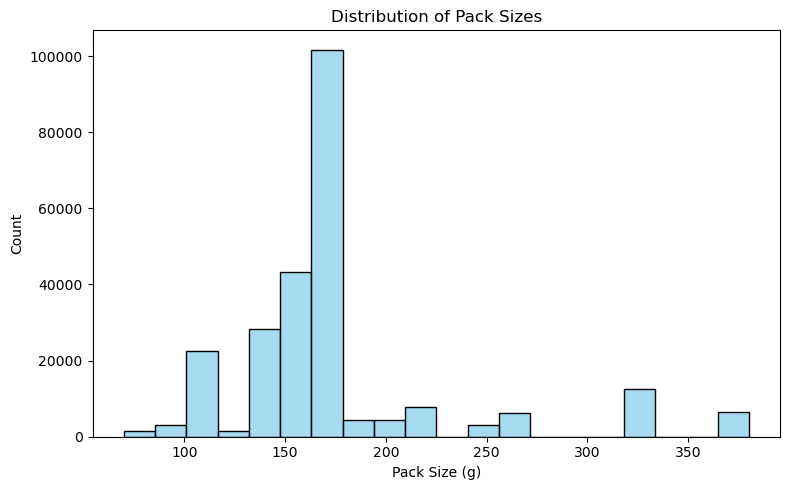

In [17]:
plt.figure(figsize=(8,5))
sns.histplot(data["PACK_SIZE"], bins=20, kde=False, color="skyblue")
plt.title("Distribution of Pack Sizes")
plt.xlabel("Pack Size (g)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

When looking at product pack sizes, the most popular was the **175g pack**, clearly standing out across transactions. Smaller sizes like 134g or 150g appeared less frequently, while jumbo sizes (e.g., 380g) showed up only occasionally.

This suggests that customers prefer a “standard” size for regular consumption, while very small or large packs serve only niche use cases.

#### Seasonal Trends

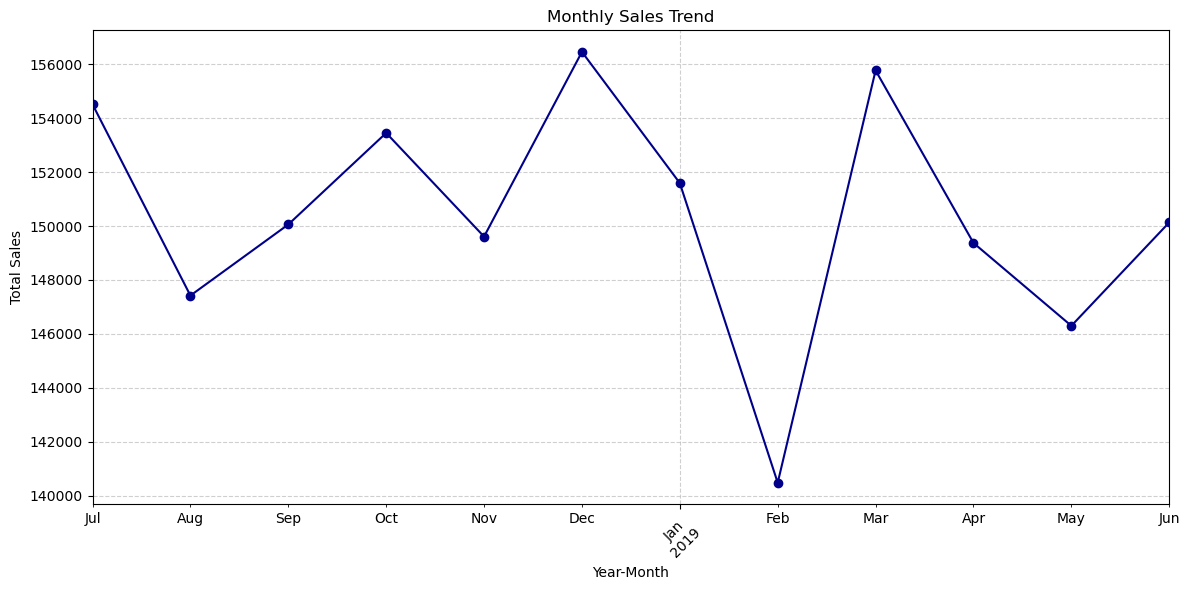

In [18]:
data["YEAR_MONTH"] = data["DATE"].dt.to_period("M")
monthly_sales = data.groupby("YEAR_MONTH")["TOT_SALES"].sum()

plt.figure(figsize=(12,6))
monthly_sales.plot(marker="o", color="darkblue")
plt.title("Monthly Sales Trend")
plt.xlabel("Year-Month")
plt.ylabel("Total Sales")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

When examining sales over time, monthly patterns reveal clear seasonal effects. Overall sales peak in December, aligning with the holiday season, followed by a dip in January–February, before gradually picking up again. This highlights the importance of planning inventory and promotions around high-demand periods.


#### Monthly Sales by Customer Segment

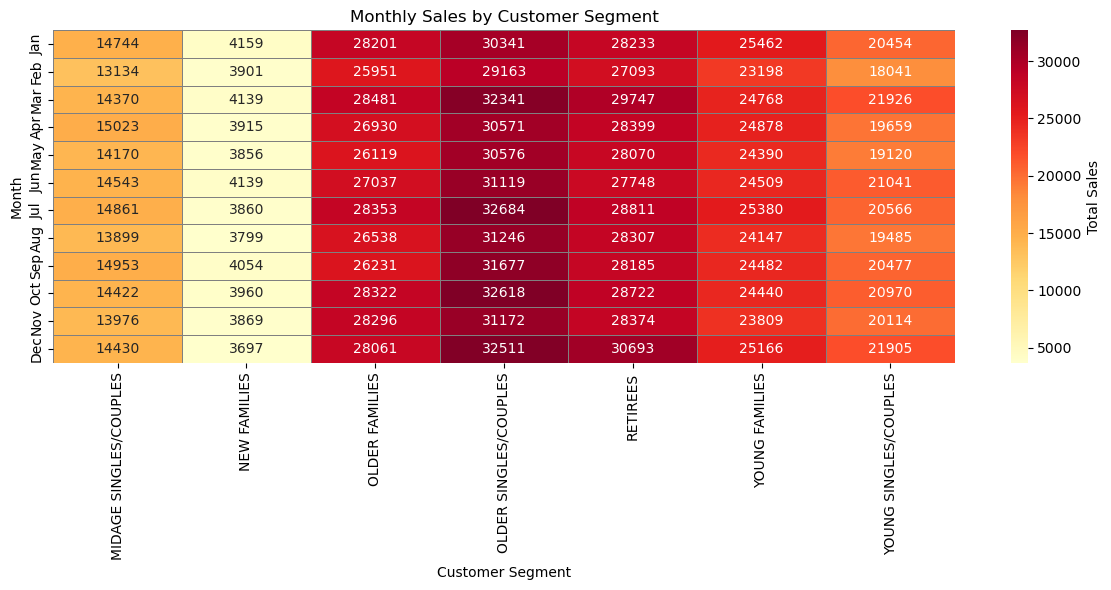

In [19]:
monthly_segment = data.pivot_table(index="MONTH_NAME", columns="LIFESTAGE", values="TOT_SALES", aggfunc="sum", observed=False)

plt.figure(figsize=(12,6))
sns.heatmap(monthly_segment, annot=True, fmt=".0f", cmap="YlOrRd", linewidths=0.5, linecolor="gray", cbar_kws={'label': 'Total Sales'})
plt.title("Monthly Sales by Customer Segment")
plt.ylabel("Month")
plt.xlabel("Customer Segment")
plt.tight_layout()
plt.show()

Looking more closely at monthly sales by customer segment, distinct purchasing behaviors emerge. Older Families and Retirees consistently generate higher sales, reflecting strong and stable demand. Young Singles/Couples show more variability, indicating irregular or less predictable shopping patterns. New Families contribute the lowest sales, often under 5,000, suggesting this segment is still small or less engaged. Meanwhile, Older Singles/Couples are key revenue drivers, with typical monthly sales between 30,000 and 32,000.


#### Customer Segments & Sales Patterns

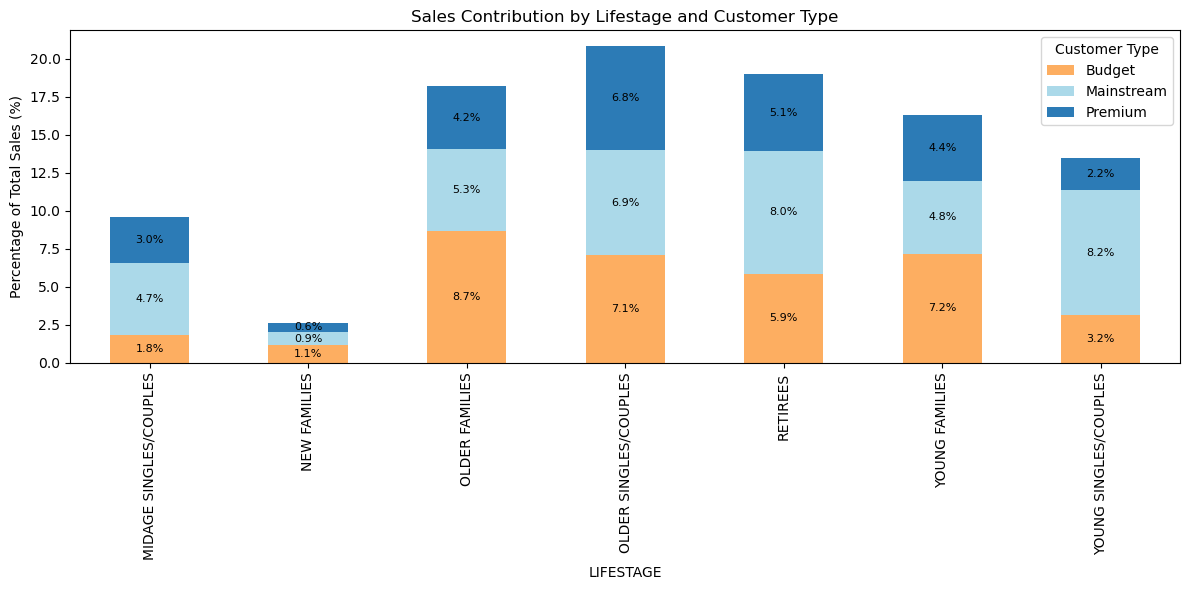

In [20]:
# Aggregate total sales by Lifestage and Premium Customer
sales_segment = data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"].sum().reset_index()

# Calculate percentage contribution per segment
total_sales = sales_segment["TOT_SALES"].sum()
sales_segment["PERCENT"] = (sales_segment["TOT_SALES"] / total_sales) * 100

# Order Premium Customer categories
sales_segment["PREMIUM_CUSTOMER"] = pd.Categorical(sales_segment["PREMIUM_CUSTOMER"], categories=["Budget", "Mainstream", "Premium"], ordered=True)

# Pivot table to prepare for stacked bar chart
pivot_sales = sales_segment.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='PERCENT')

# Plot stacked bar chart
ax = pivot_sales.plot(kind='bar', stacked=True, figsize=(12,6), color=["#fdae61", "#abd9e9", "#2c7bb6"])

plt.ylabel("Percentage of Total Sales (%)")
plt.title("Sales Contribution by Lifestage and Customer Type")
plt.xticks(rotation=90)
plt.legend(title='Customer Type')
plt.tight_layout()

# Add percentage labels in the middle of each bar
for container in ax.containers: ax.bar_label(container, fmt="%.1f%%", label_type="center", fontsize=8, color="black")

plt.show()

A breakdown by Lifestage and Customer Type reveals:

- Older Singles/Couples, Older Families, and Retirees are the most significant contributors to sales, showing consistent demand.
- Mainstream customers represent nearly 39% of total sales, forming the backbone of revenue.
- Premium customers, though smaller in number, generate higher value per visit, highlighting their importance for margin growth.

#### Brand Insights

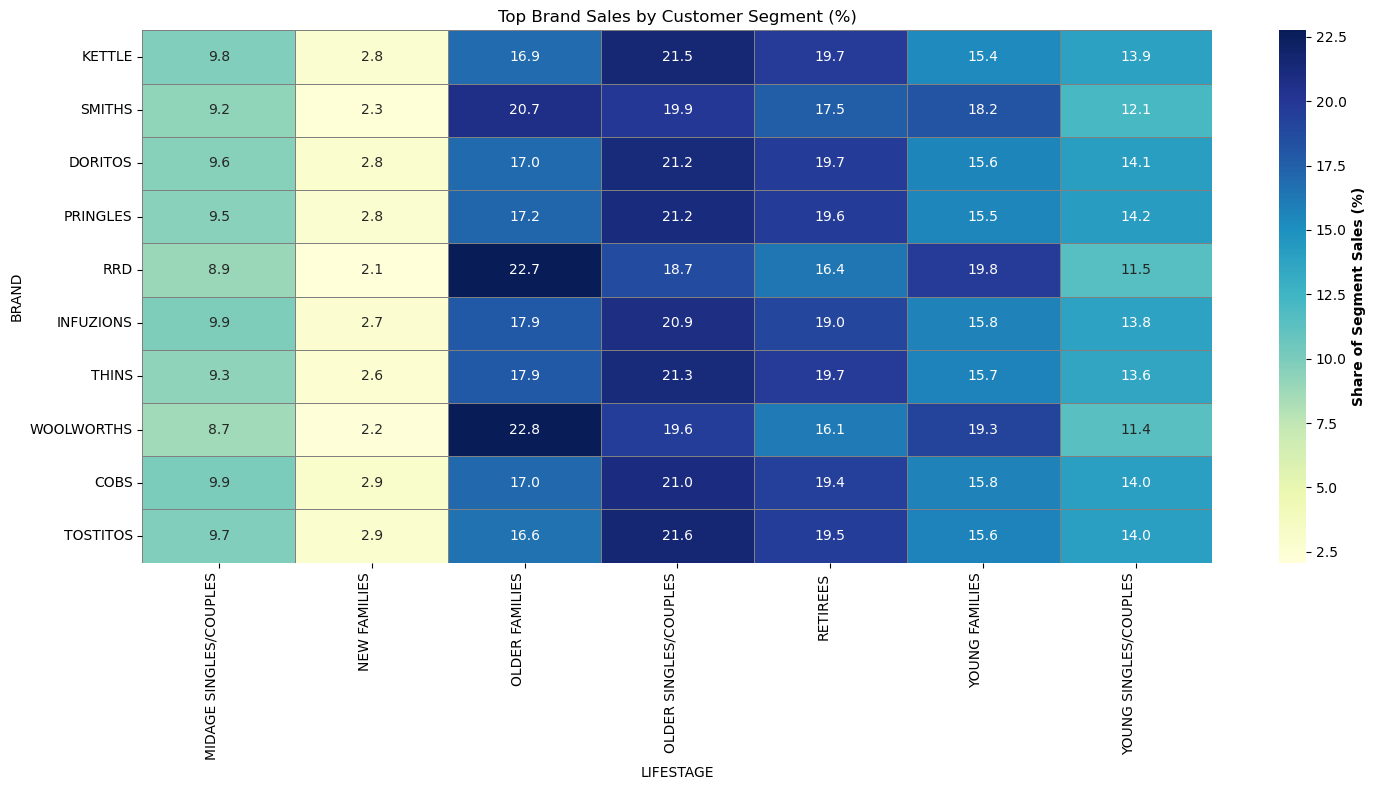

In [21]:
pivot = data.pivot_table(index='BRAND', columns='LIFESTAGE', values='PROD_QTY', aggfunc='sum', observed=False)

top_brands_total = pivot.sum(axis=1).sort_values(ascending=False).head(10).index
pivot_top = pivot.loc[top_brands_total]
pivot_pct = pivot_top.div(pivot_top.sum(axis=1), axis=0) * 100

plt.figure(figsize=(15,8))
sns.heatmap(pivot_pct, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5, linecolor='gray', 
            cbar_kws={'label': 'Share of Segment Sales (%)'})
plt.title("Top Brand Sales by Customer Segment (%)")
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.gca().collections[0].colorbar.set_label("Share of Segment Sales (%)", weight="bold")
plt.tight_layout()
plt.show()

Analysis of product names highlighted Kettle, Smiths, Doritos, Pringles, and Infuzions as the top brands, reflecting strong consumer preference, with Kettle performing consistently across all customer groups. 

The heatmap shows clear patterns across segments: 
- Kettle and Doritos are most popular among Older Singles/Couples
- Smiths appeals broadly to Older Families, Young Families, and Older Singles/Couples
- Smaller segments like Midage Singles/Couples and New Families contribute less overall but still show distinct preferences


#### Purchase Behavior

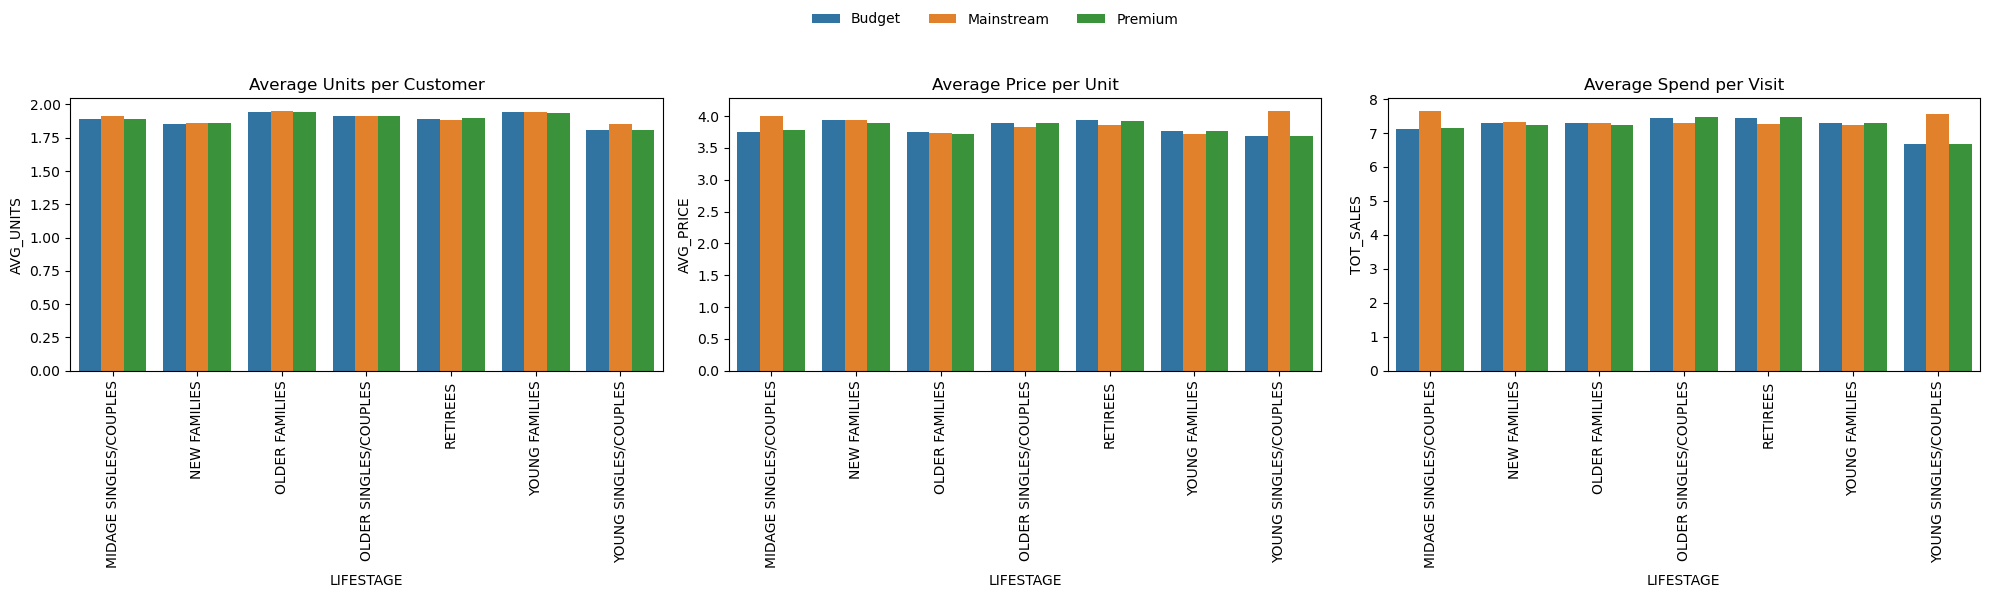

In [22]:
# Aggregate data for Units & Price
agg_segment = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(
    AVG_UNITS=('PROD_QTY', 'mean'),
    AVG_PRICE=('TOT_SALES', lambda x: x.sum() / data.loc[x.index, "PROD_QTY"].sum())).reset_index()

# Aggregate data for Spend
spend_visit = data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])['TOT_SALES'].mean().reset_index()

# Create 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20,6), sharey=False)

# Plot 1: Average Units
sns.barplot(data=agg_segment, x="LIFESTAGE", y="AVG_UNITS", hue="PREMIUM_CUSTOMER", ax=axes[0], legend=False)
axes[0].set_title("Average Units per Customer")
axes[0].tick_params(axis="x", rotation=90)

# Plot 2: Average Price
sns.barplot(data=agg_segment, x="LIFESTAGE", y="AVG_PRICE", hue="PREMIUM_CUSTOMER", ax=axes[1], legend=False)
axes[1].set_title("Average Price per Unit")
axes[1].tick_params(axis="x", rotation=90)

# Plot 3: Average Spend
sns.barplot(data=spend_visit, x="LIFESTAGE", y="TOT_SALES", hue="PREMIUM_CUSTOMER", ax=axes[2])
axes[2].set_title("Average Spend per Visit")
axes[2].tick_params(axis="x", rotation=90)

# Extract legend from last subplot
handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend_.remove()  # remove from subplot
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)

plt.tight_layout(rect=[0,0,1,0.9])  # leave space for global legend
plt.show()

Analysis of units, price, and spend shows:

- Premium customers purchased fewer items per basket but paid a higher unit price, reflecting premium product choices
- Mainstream and Budget customers tended to buy more units per trip, particularly Older Families
- Despite smaller baskets, Premium customers spent more per visit on average, while Young and Midage Singles showed lower transaction values

## Conclusion

Based on the exploration of chip purchasing data across customer segments and time periods, several key patterns emerge. Standard pack sizes (around 175g) dominate sales, forming the core category, while December consistently drives a peak in demand, reflecting seasonal shopping patterns. Premium customers, although buying smaller baskets, contribute disproportionately to revenue, making them a high-value segment. Older Families and Retirees continue to form the backbone of mainstream sales, ensuring steady volume.

**Strategic Implication:** Retailers can maximize ROI by focusing premium promotions on high-value customers for margin growth, while designing volume-driven campaigns targeting mainstream family and senior segments to maintain consistent sales.